<a href="https://colab.research.google.com/github/JeanLuc-Oudshoorn/Stochastic_Linear_Programming/blob/main/quadratic_portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quadratic Programming: Portfolio Optimization Under Uncertainty

In this notebook quadratic programming will be used to find the optimal portfolio allocation under randomly sampled scenarios. The scenarios are constructed by means of bootstrapping empirical observations. The data are daily returns of 55 well-performing assets from the last 20 years, downloaded through the API of Yahoo finance. The goal will be to decide how to allocate a portfolio, based on a give risk tolerance.

The key assumption is that randomly sampled daily returns of the past 20 years are indicative of how a stock is likely to perform in the future. This method penalizes stocks that have seen large up- and downswings, because in at least some of the simulated scenarios daily returns of the downswing will be disproportionally sampled. This means that the assigned weights to these stocks are highly variable across scenarios, thus providing a measure of risk. By the same token, stocks that have seen a slow but steady climb upwards will be preferred.

The first step is to install the quadratic programming framework ```cvxpy```.

In [64]:
!pip install cvxpy

In [65]:
import numpy as np
import pandas as pd
import cvxpy as cp
import yfinance as yf
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=UserWarning)

We will be exclusively analysing high-profile stocks that have traded actively for 20 years. Stocks have been pre-screened to fulfill two criteria:


1.   Relatively good returns over the past 20 years
2.   Uninterrupted trading since 2004

The reason for the first criterium is that if a stock has seen meager returns, it is very unlikely to be assigned any weight by the solver since the objective is to maximize returns. Additionally, the number of stocks to consider must be limited somehow in order to keep the computational expense reasonable.

The reason for the second criterium is that stocks that have performed well over a two decade period may be considered strong performers in general, as opposed to stocks that have only performed stronlgy over the most recent 1-3 years. Thus, hypothetically, the performance of these stocks should generalize better to the future. Nevertheless, this is an assumption that is not directly verified here.



In [66]:
# Create a list of Yahoo stock tickers
stocks = ['VTI', 'VGT', 'EZU', 'QQQ', 'ASML', 'TSM', 'NVDA', 'VRTX', 'UBI.PA',
          'GOOGL', 'AAPL', 'AMZN', 'EWZ', 'EEM', 'MSFT', 'DIS', 'CDI.PA',
          'BRK-B', 'UBSG.SW', 'NTDOY', 'CRM', 'CAP.PA', 'INFY', 'JPM', 'NBIX',
          'ORCL', 'MC.PA', 'RMS.PA', 'ADBE', 'VBR', 'VBK', 'ACN', '0700.HK',
          'SMSN.IL', 'TTWO', 'PFE', 'JNJ', 'GS', 'QCOM', 'APH', 'NVR', 'DHI',
          'NEE', 'RMD', 'POOL', 'AIR.PA', 'BLK', 'LMT', 'NOC', 'VOF.L', 'CNC',
          'ATVI', 'UNH', 'DEO', 'NTES']

The closing prices of the stocks can be downloaded as follows and converted into log returns.

In [67]:
# Fetch the closing prices using the Tickers method
tickers_data = yf.Tickers(' '.join(stocks))

# Get historical data for closing prices
closing_prices = tickers_data.history(start=datetime(2004, 11, 1),
                                      end=datetime(2023, 7, 1),
                                      interval='1d')['Close'].dropna()

# Convert the data into a pandas DataFrame
returns = (np.log(closing_prices / closing_prices.shift(1))).dropna()

# Inspect the data
print("\n", returns.iloc[:6, :6])

# Save log returns for later use
returns.to_csv('yahoo_stocks.csv', index=False)

[*********************100%***********************]  55 of 55 completed

              0700.HK      AAPL       ACN      ADBE    AIR.PA      AMZN
Date                                                                  
2004-11-02  0.037338  0.019821  0.015677  0.012173  0.014515  0.031962
2004-11-03 -0.015832  0.033273  0.008559  0.002277  0.003923 -0.008869
2004-11-04 -0.060292 -0.015672  0.019691  0.016483  0.000435  0.027188
2004-11-05  0.016807  0.004947 -0.005587  0.006347 -0.005668 -0.009528
2004-11-08  0.000000 -0.006234 -0.023892 -0.010658  0.012601  0.020575
2004-11-09  0.011050 -0.006086  0.009382 -0.008156 -0.007802  0.002141


We can save the dataframe for later use, and optionally truncate it.

In [68]:
# Read in the daily stock returns
returns = pd.read_csv('yahoo_stocks.csv')

# Optionally consider only more recent return data
# returns = returns.iloc[1000:, :]

The risk tolerance and number of scenarios must be defined before modeling starts. Additionally the indices must be extracted so they can be randomly sampled later.

In [69]:

# Define risk tolerance and number of scenarios
risk_tolerance = 0.016
num_scenarios = 2000
n_assets = len(returns.columns)
inds = returns.index

# Create empyt lists to save weights and expected returns
weights_samples = []
expected_return = []

Now we create a new scenario on each iteration of the loop, where 2000 observations are randomly sampled from the 4000 or so daily returns per asset. The reason to sample less observations is to increase the stochasticity. In essence, we are hedging for the risk that historical performance may only be mildly associated with future performance.

It is also possible to do a proper bootstrap, in which case the number of samples will be equal to the original number of observations. Results will be more stable across scenarios in this case.

Next, the problem is defined with three constrains:


1.   No shorting: all weights must be positive
2.   Fully invested: all weights must sum up to one
3.   The variance of the portfolio must be lower than the pre-defined risk tolerance.

The solution of each quadratic programming loop is appended to two lists storing the results.



In [70]:
# Perform quadratic programming for every scenario
for i in range(num_scenarios):

    # Pick random rows with replacement from data (bootstrapping)
    chosen_inds = np.random.choice(inds, size=2000)     # Optionally change size
    bootstrap_frame = returns.loc[chosen_inds, :]

    # Compute the mean return per asset and covariance matrix
    mean_returns = bootstrap_frame.mean().values
    covariance_matrix = bootstrap_frame.cov().values

    # Create a variable for the weights per asset
    w = cp.Variable(n_assets)

    # Maximize expected return
    objective = cp.Maximize(mean_returns @ w)

    # No shorting, fully invested, variance of the portfolio stays under risk tolerance
    constraints = [w >= 0, cp.sum(w) == 1, cp.quad_form(w, covariance_matrix) <= risk_tolerance**2]

    # Define problem
    problem = cp.Problem(objective, constraints)

    # Check if the problem is feasible
    if problem.is_dcp() and problem.is_dpp():
        problem.solve()
        weights_samples.append(w.value)
        expected_return.append(mean_returns @ w.value)
    else:
        print("The optimization problem is infeasible.")

Now we can convert the lists into a dataframe and analyse the results. An overview of what the results look like has been given below. The expected return per scenario is stored in the index. The data is also sorted to show the highest expected returns first.

In [119]:
# Create a dataframe of the obtained results
weights_per_run = pd.DataFrame(weights_samples, index=expected_return, columns=returns.columns)

# Sort the dataframe by best runs first
weights_per_run.sort_index(ascending=False, inplace=True)

# Show weights per run
print(weights_per_run.iloc[:6, :4])

               0700.HK          AAPL           ACN          ADBE
0.002516  2.106287e-02  3.595662e-01  2.465984e-08  1.703176e-08
0.002488  1.015326e-01  3.855662e-01  2.872601e-08  1.713786e-08
0.002471  6.043026e-08  3.552495e-01  1.944804e-08  1.425801e-08
0.002468  2.661916e-01  3.062255e-01  3.307687e-09  2.727132e-09
0.002413  1.924371e-01  8.457371e-08  5.050678e-08  2.962095e-01
0.002387  1.858743e-01  8.997635e-07  3.593744e-07  3.417226e-08


We can extract the mean allocation of each stock for the 25% best scenarios (those with the highest expected return), to check what stocks we may want to invest in if we are expecting a bullish market.

In [72]:
# Print optimal allocations for high, medium and low return simulations
print("Mean Allocations for Simulations with High Return Expectation:")

print(weights_per_run.iloc[:500, :]                 # Only top results
                .describe().loc[['mean', 'std'], :]
                .sort_values(by='mean', axis=1, ascending=False)
                .round(3)
                .T[:15])

assert round(weights_per_run.iloc[:500, :].mean().sort_values(ascending=False).sum()) == 1

Mean Allocations for Simulations with High Return Expectation:
          mean    std
0700.HK  0.217  0.165
AAPL     0.148  0.178
RMS.PA   0.073  0.133
NVDA     0.070  0.096
AMZN     0.048  0.095
VRTX     0.037  0.077
NTES     0.037  0.079
ASML     0.030  0.080
ATVI     0.024  0.074
SMSN.IL  0.023  0.072
CNC      0.022  0.065
RMD      0.022  0.068
CRM      0.020  0.057
UNH      0.017  0.057
UBI.PA   0.015  0.053


The same process can be repeated for the middle 50%, and worst 25% of scenarios.

In [73]:
print("Mean Allocations for Simulations with Medium Return Expectation:")

print(weights_per_run.iloc[500:1500, :]                 # Medium results
                .describe().loc[['mean', 'std'], :]
                .sort_values(by='mean', axis=1, ascending=False)
                .round(3)
                .T[:15])

assert round(weights_per_run.iloc[500:1500, :].mean().sort_values(ascending=False).sum()) == 1

Mean Allocations for Simulations with Medium Return Expectation:
          mean    std
0700.HK  0.201  0.168
AAPL     0.144  0.188
RMS.PA   0.080  0.144
NVDA     0.060  0.090
AMZN     0.043  0.097
NTES     0.034  0.083
RMD      0.031  0.099
VRTX     0.029  0.069
ASML     0.028  0.081
SMSN.IL  0.026  0.079
ATVI     0.026  0.083
CNC      0.021  0.066
CRM      0.019  0.062
NEE      0.018  0.069
UNH      0.017  0.073


In [74]:
print("Mean Allocations for Simulations with Low Return Expectation:")

print(weights_per_run.iloc[1500:, :]                 # Worst results
                .describe().loc[['mean', 'std'], :]
                .sort_values(by='mean', axis=1, ascending=False)
                .round(3)
                .T[:15])

assert round(weights_per_run.iloc[1500:, :].mean().sort_values(ascending=False).sum()) == 1

Mean Allocations for Simulations with Low Return Expectation:
          mean    std
0700.HK  0.183  0.174
AAPL     0.125  0.183
RMS.PA   0.111  0.187
AMZN     0.048  0.113
NVDA     0.041  0.079
SMSN.IL  0.039  0.106
RMD      0.031  0.098
ATVI     0.030  0.081
NTES     0.028  0.082
LMT      0.028  0.094
VRTX     0.027  0.069
UNH      0.026  0.097
NEE      0.022  0.084
NOC      0.022  0.085
CDI.PA   0.017  0.082


Interestingly, the preferred allocation changes only mildly. Under scenarios with lower expected returns tech stocks appear to be less good options, as indicated by Tencent, Apple and Nvidia. On the other hand, Amazon appears to be more or less stable, while Hermès is more popular in the worse scenarios.

Another sensible metric is to check in what proportion of scenarios each stock was assigned a non-zero weight (non-zero is defined as at least 1% percent weighing). Stocks with a high score can be considered good choices under many scenarios.

In [116]:
((weights_per_run >= 0.01).sum() / num_scenarios).sort_values(ascending=False)[:15]

0700.HK    0.7645
AAPL       0.5300
RMS.PA     0.4135
NVDA       0.3935
VOF.L      0.2710
AMZN       0.2570
VRTX       0.2355
NTES       0.2190
SMSN.IL    0.1870
ATVI       0.1710
RMD        0.1625
ASML       0.1505
CNC        0.1505
CRM        0.1345
UBI.PA     0.1240
dtype: float64

A correlation heatmap can be made to show the relation between changes in different asset weights among each other. The heatmap shows what happens to the weights of other stocks if the weight of a given stock increases. Naturally, it would make more sense if the weight of other stocks decrease, as the total weight can only add up to one, so any increase in the weight of one stock must be compensated somewhere else.

There seems to be a relatively strong trade-off between Apple and Tencent, and Apple and Nvidia. When one increases the other decreases.

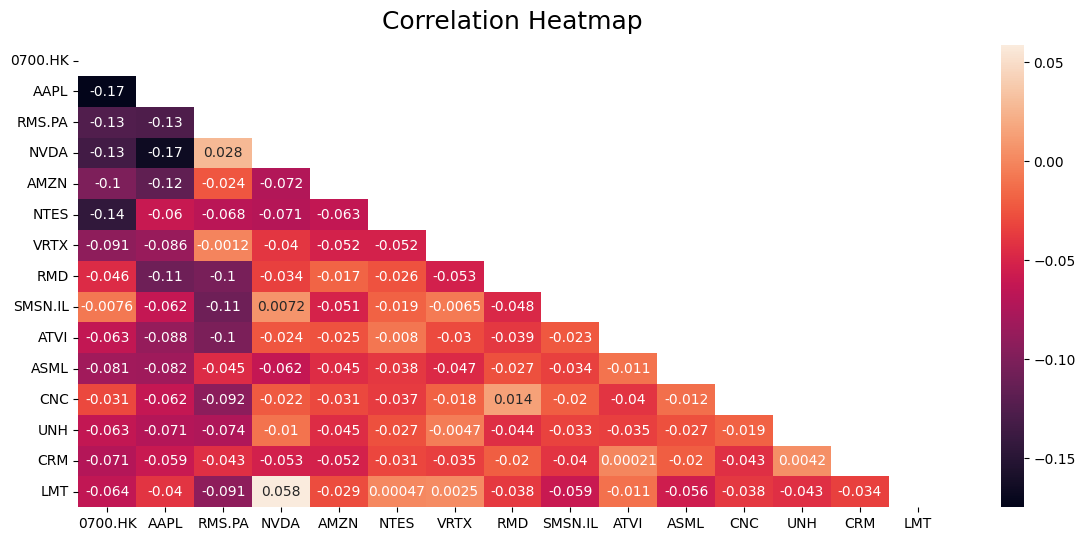

In [80]:
most_important_stocks = list(weights_per_run.mean()
                                            .sort_values(ascending=False)[:15]
                                            .index)

mask = np.triu(np.ones_like(weights_per_run[most_important_stocks].corr(),
                            dtype=bool))

plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(weights_per_run[most_important_stocks].corr(),
                      annot=True, mask = mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

It would be possible to create a boxplot of the weights that were obtained per scenario per asset. However, it's important to note that boxplots consider the median as the middle point of this. Most assets received zero weight in more than 75% of runs, which makes the boxplot unsuitable.

Alternatively, a stripplot can be considered. This can give us information on the amount of scenarios where a weight was assigned to an asset. If the plot is densely populated, it can be inferred that a given weight was assigned often.



Text(0.5, 1.0, 'Stripplot of Weights per Scenario')

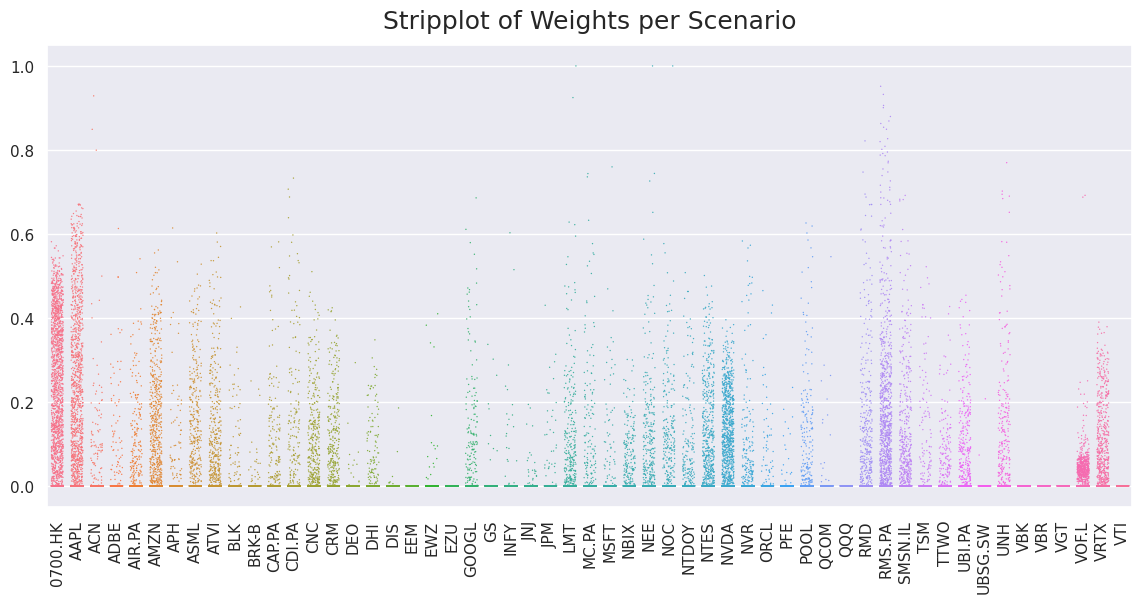

In [115]:
plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
sns.set_theme()
sns.stripplot(weights_per_run, size=1, alpha=0.9, jitter=0.3)
plt.title('Stripplot of Weights per Scenario', fontdict={'fontsize':18}, pad=12)

It turn out that Tencent was assigned a non-zero weight most often, however it was never assigned a weight of greater than 0.6. In comparison, the weights assigned to Apple are a little more spread out. Hermès is also notable, often being assigned weights in the 0-20% range, but in some scenarios over 90%. The Vietnam Opportunity Fund, listed in London, has an especially high density in the 0-10% range, but almost never higher. This might be because Vietnamese private equity provides a nice diversification boost to a portfolio, but the returns are not great enough to justify weighing it more than 10%.